### Import Libraries

In [1]:
%matplotlib inline
import os

import cv2
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import Dice
from torchvision import transforms
from torchmetrics.classification import BinaryConfusionMatrix

from utilities import AITEXPatchedSegmentation
from model_architectures import BinaryClassifier, MiniUNet


c:\compute\envs\fdd\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\compute\envs\fdd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Data

In [2]:
# Define paths
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
model_dir = os.path.join(root, "models")
data_dir = os.path.join(root, "data")
aitex_dir = os.path.join(data_dir, "aitex")

# Load dataset with transforms and split
transform = transforms.Compose([
    transforms.Resize((224, 224))
])
data = AITEXPatchedSegmentation(aitex_dir, transform=transform)#, normal_only=True)
num_samples = len(data)
train_samples = int(num_samples * 0.95)
val_samples = num_samples - train_samples
train, val = random_split(data, [train_samples, val_samples])


### Model Defs

In [3]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc


class TverskyLoss(nn.Module):
    def __init__(self):
        super(TverskyLoss, self).__init__()
        self.smooth = 1.0
        self.alpha = 0.7

    def forward(self, y_true, y_pred):
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        
        tp = (y_true_flat * y_pred_flat).sum()
        fn = (y_true_flat * (1 - y_pred_flat)).sum()
        fp = ((1 - y_true_flat) * y_pred_flat).sum()
        
        return 1 - (tp + self.smooth) / (tp + self.alpha * fn + (1 - self.alpha) * fp + self.smooth)
    



### Try Using Mini UNet

In [20]:
model = MiniUNet(1)
model.cuda()

device = "cuda"
dice = TverskyLoss()
optimizer = Adam(model.parameters(), lr=1e-2)
new_shape = (1, 1, 224, 224)

model.train()

for epoch in range(0, 50):
    loss_train = []
    for i, (img, mask, label) in enumerate(data):
        x = img.reshape(new_shape).to(device)
        y = mask.reshape(new_shape).to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = dice(y, y_pred)

        loss_train.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch, "Loss:", np.mean(loss_train))

Epoch: 0 Loss: 0.6769687958665797
Epoch: 1 Loss: 0.6585613624469654
Epoch: 2 Loss: 0.624007688341914
Epoch: 3 Loss: 0.3630079130868654
Epoch: 4 Loss: 0.14468667861577628
Epoch: 5 Loss: 0.08426099757890443
Epoch: 6 Loss: 0.7785990927670453
Epoch: 7 Loss: 0.7114223431896519
Epoch: 8 Loss: 0.611326957393337
Epoch: 9 Loss: 0.46476068561141554
Epoch: 10 Loss: 0.2648826170612026
Epoch: 11 Loss: 0.18376200972376644
Epoch: 12 Loss: 0.1438408197583379
Epoch: 13 Loss: 0.12376534423312625
Epoch: 14 Loss: 0.16584980294511126
Epoch: 15 Loss: 0.20375071216273952
Epoch: 16 Loss: 0.10918345902417158
Epoch: 17 Loss: 0.05786420300200179
Epoch: 18 Loss: -0.02614491340276357
Epoch: 19 Loss: -0.04233119745512266
Epoch: 20 Loss: -0.08421048022605278
Epoch: 21 Loss: -0.15340062347618308
Epoch: 22 Loss: -0.20052290574924367
Epoch: 23 Loss: -0.3326367548994116
Epoch: 24 Loss: 0.6797237470343306
Epoch: 25 Loss: 0.8291397658554284
Epoch: 26 Loss: 1.053769201523549
Epoch: 27 Loss: 1.0451252663457715
Epoch: 28 Los

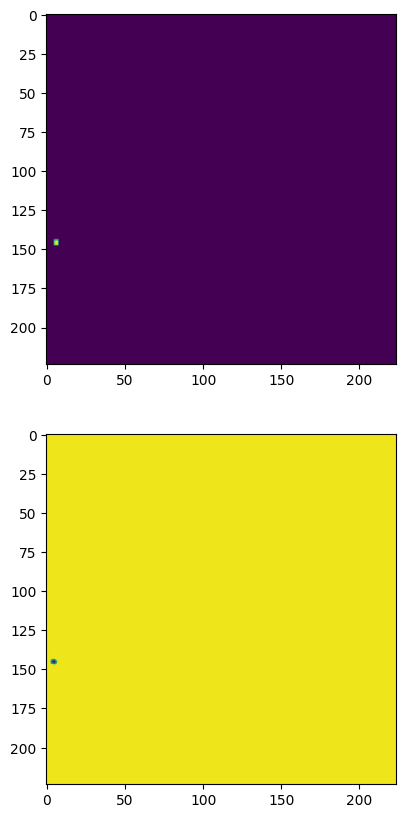

In [21]:
fig, ax = plt.subplots(2, figsize=(10,10))

ax[0].imshow(y.cpu().detach().numpy().reshape((224, 224)))
ax[1].imshow(y_pred.cpu().detach().numpy().reshape((224, 224)))

In [36]:
torch.amax(y_pred)

tensor(0.2266, device='cuda:0')

c:\compute\envs\fdd\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


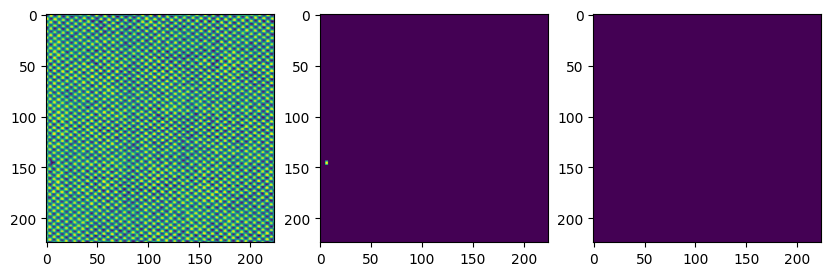

In [34]:
model.eval()

img, mask, label = data[-1]
x = img.reshape(new_shape).to(device)
with torch.no_grad():
    y_pred = model(x)

fig, ax = plt.subplots(1, 3, figsize=(10,10))

ax[0].imshow(x.cpu().detach().numpy().reshape((224, 224)))
ax[1].imshow(mask.reshape((224, 224)))
ax[2].imshow(y_pred.cpu().detach().numpy().reshape((224, 224)))

### Another UNet

In [37]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p
    
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

In [38]:
model = build_unet()
model.cuda()

device = "cuda"
dice = DiceLoss()
optimizer = Adam(model.parameters(), lr=1e-3)
new_shape = (1, 1, 224, 224)

model.train()

for epoch in range(0, 50):
    loss_train = []
    for i, (img, mask, label) in enumerate(data):
        x = img.reshape(new_shape).to(device)
        y = mask.reshape(new_shape).to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = dice(y, y_pred)

        loss_train.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch, "Loss:", np.mean(loss_train))

c:\compute\envs\fdd\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 0 Loss: 0.6705634642291713
Epoch: 1 Loss: 1.2336661905855746
Epoch: 2 Loss: 0.9020738273053556
Epoch: 3 Loss: 0.859293904820004
Epoch: 4 Loss: 0.8393617085508398
Epoch: 5 Loss: 0.8190927537711891
Epoch: 6 Loss: 0.7936899852108311
Epoch: 7 Loss: 0.7509637417020024
Epoch: 8 Loss: 0.33873418666221
Epoch: 9 Loss: 0.689959543137937
Epoch: 10 Loss: 0.647460409435066
Epoch: 11 Loss: 0.6002634071015023
Epoch: 12 Loss: 0.5521663105165636
Epoch: 13 Loss: 0.48924274895642256
Epoch: 14 Loss: 0.3988482546161961
Epoch: 15 Loss: 0.2561976071950552
Epoch: 16 Loss: -0.09466880527702538


KeyboardInterrupt: 

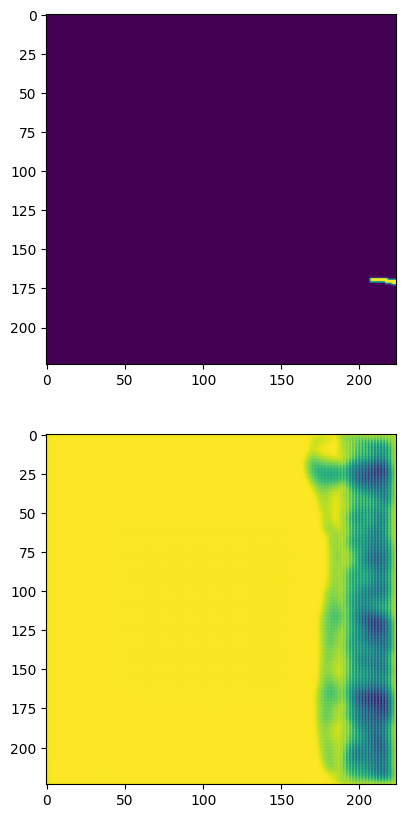

In [39]:
fig, ax = plt.subplots(2, figsize=(10,10))

ax[0].imshow(y.cpu().detach().numpy().reshape((224, 224)))
ax[1].imshow(y_pred.cpu().detach().numpy().reshape((224, 224)))

### Little UNet

In [11]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x2

In [16]:
model = UNet()
model.cuda()

device = "cuda"
dice = DiceLoss()
optimizer = Adam(model.parameters(), lr=1e-2)
new_shape = (1, 1, 224, 224)

model.train()

for epoch in range(0, 20):
    loss_train = []
    for i, (img, mask) in enumerate(data):
        x = img.reshape(new_shape).to(device)
        y = mask.reshape(new_shape).to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = dice(y, y_pred)

        loss_train.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch, "Loss:", np.mean(loss_train))
    if np.mean(loss_train) < 0.4:
        break

Epoch: 0 Loss: 0.9078569170590993
Epoch: 1 Loss: 0.8182646690188228
Epoch: 2 Loss: 0.8771640455400621
Epoch: 3 Loss: 0.8449600925316681
Epoch: 4 Loss: 0.9367710783674911
Epoch: 5 Loss: 0.9334297318716307
Epoch: 6 Loss: 0.9182123593381933
Epoch: 7 Loss: 0.5324322387978837
Epoch: 8 Loss: 0.8551808821188437
Epoch: 9 Loss: 0.9266942143440247
Epoch: 10 Loss: 0.9256685711242058
Epoch: 11 Loss: 0.9248240393561286
Epoch: 12 Loss: 0.924139260601353
Epoch: 13 Loss: 0.9235825680397652
Epoch: 14 Loss: 0.9231252270775873
Epoch: 15 Loss: 0.9227445280229724
Epoch: 16 Loss: 0.9224233437228847
Epoch: 17 Loss: 0.9221489342483314
Epoch: 18 Loss: 0.92191178154301
Epoch: 19 Loss: 0.9217047069523786
